In [1]:
import numpy as np
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import os


In [2]:
# BST-based MaxHeapItem replacement
class BSTManager:
    def __init__(self):
        self.bst = SortedDict()  # BST to store (value, indices) pairs
        self.index_to_value = {}  # Dictionary to map indices to their values

    def add_item(self, value, indices):
        if value not in self.bst:
            self.bst[value] = []
        self.bst[value].append(indices)  # Add indices to the value's list
        self.index_to_value[indices] = value  # Update index-to-value mapping

    def delete_item(self, indices):
        if indices in self.index_to_value:
            value = self.index_to_value[indices]
            self.bst[value].remove(indices)  # Remove indices from the value's list
            if not self.bst[value]:  # If the list is empty, remove the value from the BST
                del self.bst[value]
            del self.index_to_value[indices]  # Remove from index-to-value mapping

    def pop_largest(self):
        if not self.bst:
            return None  # BST is empty
        largest_value = self.bst.keys()[-1]  # Get the largest value
        indices = self.bst[largest_value].pop(0)  # Remove the first indices with this value
        if not self.bst[largest_value]:  # If the list is empty, remove the value from the BST
            del self.bst[largest_value]
        del self.index_to_value[indices]  # Remove from index-to-value mapping
        return largest_value, indices

    def update_item(self, indices, new_value):
        self.delete_item(indices)  # Remove the old value
        self.add_item(new_value, indices)  # Add the new value

In [3]:
# Simulation functions
def change_spin_at(i, j, k, state):
    spins[i, j, k] = state
    if state == 1:
        bst_manager.delete_item((i, j, k))

def change_field_at(i, j, k, delF):
    if spins[i, j, k] == -1:
        old_value = local_fields[i, j, k]
        new_value = old_value + delF
        bst_manager.update_item((i, j, k), new_value)
        local_fields[i, j, k] = new_value

def flip(i, j, k, queue, avl, time):
    i, j, k = i % N, j % N, k % N
    change_spin_at(i, j, k, state=1)
    avalanches[i, j, k] = avl
    times[i, j, k] = time

    neighbours = [
        [(i + 1) % N, j, k], [(i - 1) % N, j, k],
        [i, (j + 1) % N, k], [i, (j - 1) % N, k],
        [i, j, (k + 1) % N], [i, j, (k - 1) % N]
    ]
    for neighbour in neighbours:
        if spins[neighbour[0], neighbour[1], neighbour[2]] == -1:
            change_field_at(neighbour[0], neighbour[1], neighbour[2], 2 * J)
            queue.append((neighbour[0], neighbour[1], neighbour[2]))

def avalanche_statistics(avalanches_array, times_array):
    max_avalanche_id = int(np.max(avalanches_array))
    avalanche_sizes = np.zeros(max_avalanche_id + 1, dtype=np.int64)
    avalanche_start_times = np.zeros(max_avalanche_id + 1, dtype=np.int64)
    avalanche_end_times = np.zeros(max_avalanche_id + 1, dtype=np.int64)

    for avalanche_id, flip_time in zip(avalanches_array.flat, times_array.flat):
        if avalanche_id == 0:
            continue
        if avalanche_sizes[avalanche_id] == 0:
            avalanche_start_times[avalanche_id] = flip_time
            avalanche_end_times[avalanche_id] = flip_time
        avalanche_start_times[avalanche_id] = min(avalanche_start_times[avalanche_id], flip_time)
        avalanche_end_times[avalanche_id] = max(avalanche_end_times[avalanche_id], flip_time)
        avalanche_sizes[avalanche_id] += 1

    avalanche_sizes = avalanche_sizes[1:]
    avalanche_start_times = avalanche_start_times[1:]
    avalanche_end_times = avalanche_end_times[1:]
    avalanche_durations = avalanche_end_times - avalanche_start_times + 1

    return avalanche_sizes, avalanche_durations

In [4]:
def generate_correlated_gaussian_matrix_fft_3d(n, R, correlation_length):
    # Generate white noise field
    white_noise = np.random.normal(0, 1, (n, n, n))

    # Compute the wavevectors in 3D
    kx = np.fft.fftfreq(n).reshape(n, 1, 1)
    ky = np.fft.fftfreq(n).reshape(1, n, 1)
    kz = np.fft.fftfreq(n).reshape(1, 1, n)

    # Compute the magnitude of the wavevector
    k = np.sqrt(kx**2 + ky**2 + kz**2)

    # Avoid division by zero at k = 0
    k[0, 0, 0] = 1.0

    # Power spectrum (k^(-correlation_length))
    power_spectrum = k**(-correlation_length)

    # Apply the power spectrum to the white noise field
    white_noise_fourier = np.fft.fftn(white_noise)
    correlated_field_fourier = white_noise_fourier * np.sqrt(power_spectrum)
    correlated_field = np.fft.ifftn(correlated_field_fourier).real

    # Normalize the field to have the desired RMS value R
    correlated_field *= R / np.sqrt(np.mean(correlated_field**2))

    return correlated_field

# def generate_correlated_gaussian_matrix_fft_3d(n, R, correlation_length):
#     # Generate white noise field
#     white_noise = np.random.normal(0, 1, (n, n, n))

#     # Compute the wavevectors in 3D
#     kx = np.fft.fftfreq(n).reshape(n, 1, 1)
#     ky = np.fft.fftfreq(n).reshape(1, n, 1)
#     kz = np.fft.fftfreq(n).reshape(1, 1, n)

#     # Compute the magnitude of the wavevector
#     k = np.sqrt(kx**2 + ky**2 + kz**2)

#     # Avoid division by zero at k = 0
#     k[0, 0, 0] = 1.0

#     # Power spectrum (k^(-correlation_length))
#     power_spectrum = k**(-correlation_length)

#     # Apply the power spectrum to the white noise field
#     white_noise_fourier = np.fft.fftn(white_noise)
#     correlated_field_fourier = white_noise_fourier * np.sqrt(power_spectrum)
#     correlated_field = np.fft.ifftn(correlated_field_fourier).real

#     # Normalize the field to have the desired RMS value R
#     correlated_field *= R / np.sqrt(np.mean(correlated_field**2))

#    return correlated_field

In [5]:
#####
# ? Single sim params
####

# Initialize parameters
N = 100
J = 1

R = 2.3
correlation_length = 10

In [6]:
matrix = generate_correlated_gaussian_matrix_fft_3d(N, R, correlation_length)

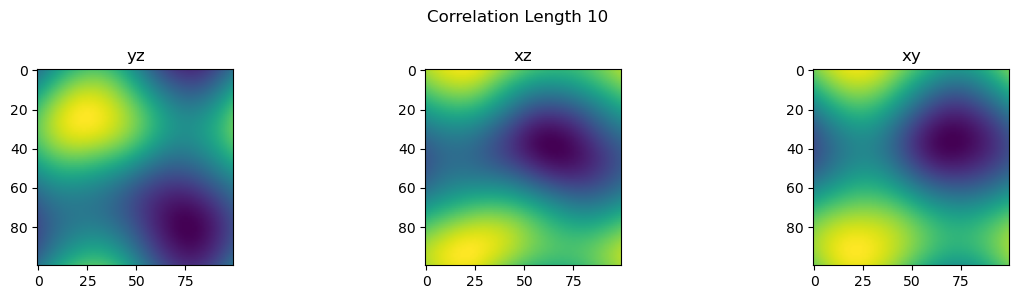

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].imshow(matrix[N//2, :, :], cmap='viridis')
ax[0].set_title("yz")
ax[1].imshow(matrix[:, N//2, :], cmap='viridis')
ax[1].set_title("xz")
ax[2].imshow(matrix[:, :, N//2], cmap='viridis')
ax[2].set_title("xy")

fig.suptitle(f"Correlation Length {correlation_length} ")
fig.tight_layout()

In [ ]:
Rs = np.linspace(0.1, 4, 25)
avalanches_for_different_Rs = []
times_for_different_Rs = []
magnetizations_for_different_Rs = []
Hs_for_different_Rs = []

for R in Rs:
    spins = -np.ones((N, N, N))
    # h = np.random.normal(0, R, (N, N, N))
    h = generate_correlated_gaussian_matrix_fft_3d(N, R, correlation_length)
    # H = -np.max(h)
    H = -N # large negative value
    local_fields = H + h
    avalanches = np.zeros((N, N, N), dtype = np.int32)
    times = np.zeros((N, N, N), dtype = np.int32)
    magnetization = []
    H_list = []

    # Initialize BST manager
    bst_manager = BSTManager()
    for i in range(N):
        for j in range(N):
            for k in range(N):
                bst_manager.add_item(local_fields[i, j, k], (i, j, k))
    
    # Simulation parameters
    spins_left = N**3
    spins_flipped = 0
    queue = []
    avl = 1
    time = 0

    with tqdm(total=spins_left, desc=f"Processing spins: R = {R}", unit="spin") as pbar:
        while spins_left > 0:
            time += 1
            if spins_flipped == 0:
                current_item = bst_manager.pop_largest()
                if current_item is None:
                    print("BST is empty. Exiting loop.")
                    break
        
                H, (i, j, k) = current_item
                spins_flipped += 1
                spins_left -= 1
                flip(i, j, k, queue, avl, time)
                pbar.update(1)  # Update the progress bar by 1 spin
                
                M = np.mean(spins)  # Compute magnetization
                
                magnetization.append(M)
                H_list.append(-H)

            else:
                spins_flipped = 0
                new_queue = []
                for (i, j, k) in queue:
                    if local_fields[i, j, k] >= H:
                        if spins[i, j, k] == -1:
                            spins_left -= 1
                            spins_flipped += 1
                            flip(i, j, k, new_queue, avl, time)
                queue = new_queue
                if spins_flipped == 0:
                    avl += 1
        
        print("Simulation completed.")
    avalanches_for_different_Rs.append(avalanches)
    times_for_different_Rs.append(times)
    magnetizations_for_different_Rs.append(magnetization)
    Hs_for_different_Rs.append(H_list)


Processing spins: R = 0.1:   0%|     | 1/1000000 [00:16<4707:31:13, 16.95s/spin]

Simulation completed.



Processing spins: R = 0.2625:   0%|  | 1/1000000 [00:16<4697:49:24, 16.91s/spin]

Simulation completed.



Processing spins: R = 0.42500000000000004:   0%| | 1/1000000 [00:17<4775:18:46, 

Simulation completed.



Processing spins: R = 0.5875:   0%|  | 1/1000000 [00:17<4787:51:23, 17.24s/spin]

Simulation completed.



Processing spins: R = 0.75:   0%|    | 1/1000000 [00:17<4821:20:36, 17.36s/spin]

Simulation completed.


In [ ]:
# Update this trial param after running the notebook everytime
trial = 1

output_filepath = f"data/correleation/N{N}/corr_length{correlation_length}/trial{trial}"
output_filename = f"simulation_data.h5"

if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)

output_file = os.path.join(output_filepath, output_filename) 

with h5py.File(output_file, 'w') as f:
    # Store Rs as a dataset
    f.create_dataset('Rs', data=Rs)
    f.create_dataset('J', data=J)  # Store J at the root level

    # Store simulation data for each R
    for idx, R in enumerate(Rs):
        group = f.create_group(f'R_{R:.2f}')
        group.create_dataset('avalanches', data=avalanches_for_different_Rs[idx])
        group.create_dataset('times', data=times_for_different_Rs[idx])
        group.create_dataset('magnetizations', data=magnetizations_for_different_Rs[idx])
        group.create_dataset('Hs', data=Hs_for_different_Rs[idx])

# with h5py.File(output_file, 'r') as f:
#     # Load Rs
#     loaded_Rs = f['Rs'][()]
#     loaded_J = f['J'][()]

#     # Load simulation data for each R
#     loaded_avalanches = [f[f'R_{R:.2f}/avalanches'][()] for R in loaded_Rs]
#     loaded_times = [f[f'R_{R:.2f}/times'][()] for R in loaded_Rs]
#     loaded_magnetizations = [f[f'R_{R:.2f}/magnetizations'][()] for R in loaded_Rs]
#     loaded_Hs = [f[f'R_{R:.2f}/Hs'][()] for R in loaded_Rs]

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))
for idx, R in enumerate(Rs[::2]):
    ax.plot(Hs_for_different_Rs[idx], magnetizations_for_different_Rs[idx], label = f"R = {R:.2f}", linewidth = 2)
ax.legend(loc = "upper right")
ax.set_xlabel("H")
ax.set_ylabel("M")


In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))

for idx, R in enumerate(Rs[4::2]):
    avalanche_sizes, avalanche_durations = avalanche_statistics(avalanches_for_different_Rs[idx], times_for_different_Rs[idx])

    hist, bin_edges = np.histogram(avalanche_sizes, bins=np.logspace(0, np.log10(max(avalanche_sizes)), 100), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Filter out zero values in the histogram (log(0) is undefined)
    valid_indices = hist > 0
    bin_centers = bin_centers[valid_indices]
    hist = hist[valid_indices]
    ax.plot(bin_centers, hist, "-", label = f"R={R:.3f}")
    
ax.set_xscale("log")
ax.set_yscale("log")

legend = ax.legend(loc = "upper right", fontsize=12)
for text in legend.get_texts():
    text.set_fontweight("bold")  

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")

# Make axis ticks bold and increase size
ax.tick_params(axis="both", which="major", labelsize=12, width=2)  # Major ticks
ax.tick_params(axis="both", which="minor", labelsize=10, width=1.5)  # Minor ticks
ax.set_xlabel(r"Avalanche Size $\mathbf{S}$", fontsize=16, fontweight = "bold")
ax.set_ylabel(r"Probability Density $\mathbf{P(S)}$", fontsize=16, fontweight = "bold")

In [ ]:
avalanche_sizes_for_different_Rs = []
avalanche_times_for_different_Rs = []

for idx, R in enumerate(Rs):
    avalanche_sizes, avalanche_times = avalanche_statistics(avalanches_for_different_Rs[idx], times_for_different_Rs[idx])
    avalanche_sizes_for_different_Rs.append(avalanche_sizes)
    avalanche_times_for_different_Rs.append(avalanche_times)

In [ ]:
def D_int(X):
    inv_sigma = 4.20  # 1/sigma
    exponent = -0.789 * (X**inv_sigma)
    polynomial = 0.021 + 0.002*X + 0.531*X**2 - 0.266*X**3 + 0.261*X**4
    return np.exp(exponent) * polynomial


In [ ]:
tau = 2.03 # Scaling exponent
sigma = 1/4.20  # Scaling exponent
R_c = 2.16   # Critical value of R
J_c = 1/R_c

In [ ]:
plt.figure(figsize=(8, 6))
for i, R in enumerate(Rs[::1]): # Starting from around R = 2.28, ending at 

    J = 1 / R
    # r = (R - R_c)/R_c


    # Compute histogram of avalanche sizes
    counts, bin_edges = np.histogram(avalanche_sizes_for_different_Rs[i], bins=np.logspace(np.log10(1), np.log10(N**3), 30), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Filter out zero counts
    nonzero_indices = counts > 0
    filtered_counts = counts[nonzero_indices]
    filtered_bin_centers = bin_centers[nonzero_indices]

    mask = (filtered_bin_centers >= 10) & (filtered_bin_centers <= 10**3)
    filtered_bin_centers_masked = filtered_bin_centers[mask]
    filtered_counts_masked = filtered_counts[mask]

    # Skip if no data points are left after masking
    if len(filtered_bin_centers_masked) == 0 or len(filtered_counts_masked) == 0:
        print(f"No valid data points for R = {R:.2f}. Skipping.")
        continue
    # Rescale for scaling collapse
    # x = (filtered_bin_centers_masked**sigma)*r
    # y = (filtered_bin_centers_masked**tau)*filtered_counts_masked
    # y = y / np.max(y)
    # y *= 0.26
    
    # x = (filtered_bin_centers_masked**sigma) * ((1/R_c) - (1/R)) / (1/R_c)
    # y = (filtered_bin_centers_masked**tau) * filtered_counts_masked

    # # Lazy normalization - couldn't get the factors right!
    # y = y / np.amax(y)
    # y *= 0.26

    x = (filtered_bin_centers_masked**sigma) * ((J_c-J)/J_c)
    y = (filtered_bin_centers_masked**tau) * filtered_counts_masked

    # Lazy normalization - couldn't get the factors right!
    y = y / np.amax(y)
    y *= 0.26

    # Plot
    plt.plot(x, y, label=f'R = {R:.2f}, J = {J:.2f}')


X_theory = np.linspace(0, 5, 500)  # Range of X for the theoretical curve
D_int_theory = D_int(X_theory)
plt.plot(X_theory, D_int_theory, 'k--', label='Theoretical $\\mathcal{D}_{\\mathrm{int}}(X)$', linewidth=2)


plt.xlabel(r"$S^\sigma J$ or $S^\sigma r$")
plt.ylabel(r"$S^\tau P(S|J)$")
plt.title('Scaling Collapse')
plt.legend(loc = "upper right")
plt.xlim(0, 2)
plt.show()


In [ ]:
# From the paper:
# lets consider the time history of the avalanches, V (t), denoting
# the number of domains flipping per unit time. (We call it
# V because it’s usually measured as a voltage in a pickup
# coil.) Each avalanche has large fluctuations, but one can
# average over many avalanches to get a typical shape. 

In [ ]:
# Function to compute V(t) for each avalanche
def compute_Vt(avalanches, times):
    avalanche_ids = np.unique(avalanches)[1:]  # Exclude 0 (no avalanche)
    Vt_dict = {}  # Dictionary to store V(t) for each avalanche

    for avl_id in avalanche_ids:
        # Get the times and indices for this avalanche
        avl_indices = np.where(avalanches == avl_id)
        avl_times = times[avl_indices]

        # Count the number of flips at each time step
        unique_times, counts = np.unique(avl_times, return_counts=True)
        Vt_dict[avl_id] = (unique_times, counts)

    return Vt_dict

# Function to align avalanches by their start time
def align_avalanches(Vt_dict):
    aligned_Vt = {}

    for avl_id, (times, counts) in Vt_dict.items():
        start_time = times[0]  # Start time of the avalanche
        aligned_times = times - start_time  # Align to t = 0
        aligned_Vt[avl_id] = (aligned_times, counts)

    return aligned_Vt

# Function to compute the average V(t)
def average_Vt(aligned_Vt, bins):
    max_time = max([max(times) for times, _ in aligned_Vt.values()])  # Maximum time across all avalanches
    time_bins = np.arange(0, max_time + 1, bins)  # Time bins for averaging
    Vt_sum = np.zeros(int(max_time // bins) + 1, dtype=float)  # Sum of V(t) for each time bin
    Vt_count = np.zeros(int(max_time // bins) + 1, dtype=int)  # Number of avalanches contributing to each time bin

    for times, counts in aligned_Vt.values():
        for t, count in zip(times, counts):
            bin_index = int(t // bins)  # Determine the bin index for the current time
            Vt_sum[bin_index] += count
            Vt_count[bin_index] += 1

    # Compute the average V(t)
    Vt_avg = np.divide(Vt_sum, Vt_count, out=np.zeros_like(Vt_sum), where=Vt_count != 0)
    return time_bins, Vt_avg


# Function to normalize the time and V(t) axes
def normalize_Vt(aligned_Vt):
    normalized_Vt = {}
    max_Vt = max([max(counts) for _, counts in aligned_Vt.values()])  # Maximum V(t) across all avalanches

    for avl_id, (times, counts) in aligned_Vt.items():
        duration = times[-1]  # Duration of the avalanche
        normalized_times = times / duration  # Normalize time to [0, 1]
        normalized_counts = counts / max_Vt  # Normalize V(t) to [0, 1]
        normalized_Vt[avl_id] = (normalized_times, normalized_counts)

    return normalized_Vt, max_Vt

# Function to compute the average normalized V(t)
def average_normalized_Vt(normalized_Vt, bins):
    time_bins = np.linspace(0, 1, bins)
    Vt_sum = np.zeros_like(time_bins, dtype=float) 
    Vt_count = np.zeros_like(time_bins, dtype=int)

    for times, counts in normalized_Vt.values():
        interp_counts = np.interp(time_bins, times, counts, left=0, right=0)
        Vt_sum += interp_counts
        Vt_count += (interp_counts > 0)

    Vt_avg = np.divide(Vt_sum, Vt_count, out=np.zeros_like(Vt_sum), where=Vt_count != 0)
    return time_bins, Vt_avg

In [ ]:
Rs

In [ ]:
# number of domains flipping per unit time
R_index = 16 
avalanches = avalanches_for_different_Rs[R_index]
times = times_for_different_Rs[R_index]
Vt_dict = compute_Vt(avalanches, times)

In [ ]:
plt.figure(figsize=(10, 6))
for avl_id, (times, counts) in Vt_dict.items():
    plt.plot(times, counts, alpha=0.5, label=f'Avalanche {avl_id}' if avl_id % 5000 == 0 else "")

plt.xlabel('Time (t)')
plt.ylabel('V(t)')
# plt.yscale("log")
# plt.xscale("log")
plt.title(f'V(t) for Individual Avalanches (R = {Rs[R_index]:.2f})')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Avalanche IDs")
plt.grid(True)
plt.show()


In [ ]:
# Align avalanches by their start time
aligned_Vt = align_avalanches(Vt_dict)

plt.figure(figsize=(10, 6))
for avl_id, (times, counts) in aligned_Vt.items():
    plt.plot(times, counts, alpha=0.5, label=f'Avalanche {avl_id}' if avl_id % 5000 == 0 else "")

plt.xlabel('Time (t)')
plt.ylabel('V(t)')
# plt.yscale("log")
# plt.xscale("log")
plt.title(f'aligned V(t) for Individual Avalanches (R = {Rs[R_index]:.2f})')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Avalanche IDs")
plt.grid(True)
plt.show()


In [ ]:
# Compute the average V(t)
bins = 10
time_bins, Vt_avg = average_Vt(aligned_Vt, bins)

# # Plot the average V(t)
# plt.figure(figsize=(10, 6))
# plt.plot(time_bins, Vt_avg, 'o-', markersize=5, label=f'R = {Rs[R_index]:.2f}')
# plt.xlabel('Time (t)')
# plt.ylabel('Average V(t)')
# plt.title(f'Average Avalanche Shape for R = {Rs[R_index]:.2f}')
# plt.legend()
# plt.grid(True)
# plt.show()

# Normalize V(t) for each avalanche
normalized_Vt, max_Vt = normalize_Vt(aligned_Vt)

# Compute the average normalized V(t)
time_bins_normalized, Vt_avg_normalized = average_normalized_Vt(normalized_Vt, bins)

# Plot the average normalized V(t)
plt.figure(figsize=(10, 6))
plt.plot(time_bins_normalized, Vt_avg_normalized, 'o-', markersize=5, label=f'R = {Rs[R_index]:.2f}')
plt.xlabel('Normalized Time (t / T)')
plt.ylabel('Normalized V(t) / V_max')
plt.title(f'Normalized Average Avalanche Shape for R = {Rs[R_index]:.2f}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compute the average V(t)
bins = 200
time_bins, Vt_avg = average_Vt(aligned_Vt, bins)

# # Plot the average V(t)
# plt.figure(figsize=(10, 6))
# plt.plot(time_bins, Vt_avg, 'o-', markersize=5, label=f'R = {Rs[R_index]:.2f}')
# plt.xlabel('Time (t)')
# plt.ylabel('Average V(t)')
# plt.title(f'Average Avalanche Shape for R = {Rs[R_index]:.2f}')
# plt.legend()
# plt.grid(True)
# plt.show()

# Normalize V(t) for each avalanche
normalized_Vt, max_Vt = normalize_Vt(aligned_Vt)

# Compute the average normalized V(t)
time_bins_normalized, Vt_avg_normalized = average_normalized_Vt(normalized_Vt, bins)

# Plot the average normalized V(t)
plt.figure(figsize=(10, 6))
plt.plot(time_bins_normalized, Vt_avg_normalized, 'o-', markersize=5, label=f'R = {Rs[R_index]:.2f}')
plt.xlabel('Normalized Time (t / T)')
plt.ylabel('Normalized V(t) / V_max')
plt.title(f'Normalized Average Avalanche Shape for R = {Rs[R_index]:.2f}')
plt.legend()
plt.grid(True)
plt.show()